In [1]:
import os
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, MaxPooling2D, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer


In [2]:
images_path = 'COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset'

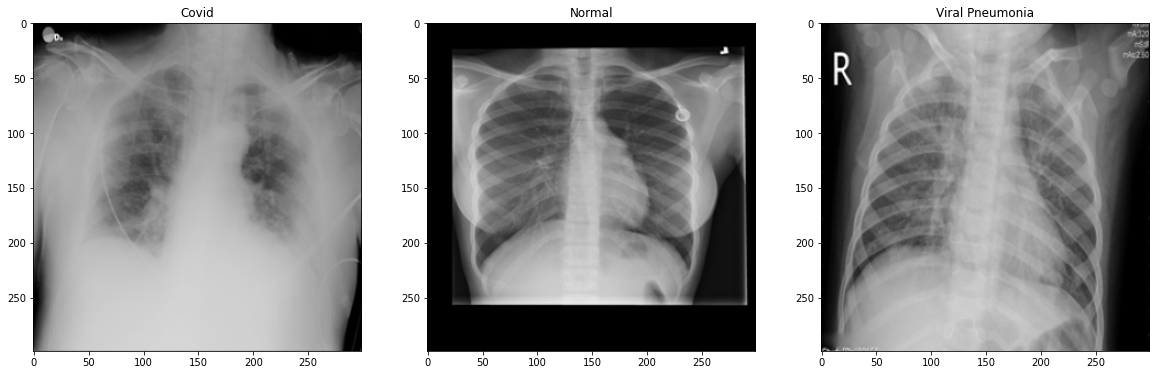

In [25]:
plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title('Covid')
plt.imshow(cv2.imread('COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\COVID\COVID-1.png'))

plt.subplot(1, 3, 2)
plt.title('Normal')
plt.imshow(cv2.imread('COVID-19_Radiography_Dataset\\COVID-19_Radiography_Dataset\\Normal\\Normal-1.png'))

plt.subplot(1, 3, 3)
plt.title('Viral Pneumonia')
plt.imshow(cv2.imread('COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\ViralPneumonia\Viral Pneumonia-1.png'))

plt.show()

# Preprocesamiento de los datos

In [42]:
filepaths=[]
labels=[]
classlist=os.listdir(images_path)
for klass in classlist:
    classpath=os.path.join(images_path,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)   

Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print('distribucion de los datos'.center(60,'-'))
print (df['labels'].value_counts())

                                           filepaths labels
0  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
1  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
2  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
3  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
4  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
-----------------distribucion de los datos------------------
Normal            10192
LungOpacity        6012
COVID              3616
ViralPneumonia     1345
Name: labels, dtype: int64


In [43]:
#Manejo de desbalance de datos, solo tomaremos 1300 imagenes de cada uno

covid_df = shuffle(df.loc[df['labels'] == 'COVID']).head(1300).reset_index(drop=True)
normal_df = shuffle(df.loc[df['labels'] == 'Normal']).head(1300).reset_index(drop=True)
viral_df = shuffle(df.loc[df['labels'] == 'ViralPneumonia']).head(1300).reset_index(drop=True)
#opacity_df = shuffle(df.loc[df['labels'] == 'Lung_Opacity']).head(1300).reset_index(drop=True)
print(covid_df.shape, normal_df.shape, viral_df.shape)


(1300, 2) (1300, 2) (1300, 2)


In [44]:
balanced_df = pd.concat([covid_df, normal_df, viral_df], ignore_index=True)
balanced_df = shuffle(balanced_df).reset_index(drop = True)
balanced_df.head()

,filepaths,labels
0,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,COVID
1,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,COVID
2,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,Normal
3,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,Normal
4,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,Normal


In [45]:
#vamos a crear 70% para entrenamiento, 15% de validacion y 15% de test

X_train, X_test = train_test_split(balanced_df, test_size=0.25, random_state=33)

X_test, X_val= train_test_split(X_test, train_size=0.5, random_state=34)


In [46]:
print(X_train.shape, X_test.shape, X_val. shape)

(2925, 2) (487, 2) (488, 2)


In [47]:
IMG_SIZE =244
le = LabelEncoder()
def preprocessig_data(data):
    X = []
    for img_path in data['filepaths']:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
        X.append(img)
    

    X = np.array(X)
    X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1))

    y= le.fit_transform(data['labels'])
    y = to_categorical(y)
    return X,y

In [48]:
x_tr, y_tr = preprocessig_data(X_train)
x_va, y_va = preprocessig_data(X_val)

In [49]:
x_tr.shape

(2925, 244, 244, 1)

# Modelo Base

 Para el modelo base usamos una red convolucional, ya que al investigar en la literatura encontramos que era la mejor opcion, sin embargo, mas adelante realizamos el experimento sin usar una red convolucional.
Ademas de la convolucion, aplanamos los datos(Flatten) y agregamos un dropuot(Dropout)

In [56]:
model_base = tf.keras.models.Sequential([
  
  Conv2D(30, kernel_size= (3,3), activation='relu', input_shape =(IMG_SIZE,IMG_SIZE,1)),
  MaxPooling2D(),
  Flatten(),
  Dense(200, activation='relu'),
  Dropout(0.2),
  Dense(3, activation= 'softmax')
])



Aplicamos early stopping para detener el modelo si no hay cambios siginificativos en el loss de la validación

In [57]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [58]:
model_base.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
history_base = model_base.fit(x_tr, y_tr, validation_data= (x_va, y_va), batch_size=40, epochs = 10, callbacks=[early])

Epoch 1/10
74/74 [==============================] - 128s 2s/step - loss: 9.2398 - accuracy: 0.6342 - val_loss: 0.5517 - val_accuracy: 0.7520
Epoch 2/10
74/74 [==============================] - 119s 2s/step - loss: 0.5468 - accuracy: 0.7774 - val_loss: 0.4816 - val_accuracy: 0.7889
Epoch 3/10
74/74 [==============================] - 125s 2s/step - loss: 0.4705 - accuracy: 0.8017 - val_loss: 0.4398 - val_accuracy: 0.7951
Epoch 4/10
74/74 [==============================] - 121s 2s/step - loss: 0.4558 - accuracy: 0.8092 - val_loss: 0.4512 - val_accuracy: 0.8033
Epoch 5/10
74/74 [==============================] - 127s 2s/step - loss: 0.4231 - accuracy: 0.8229 - val_loss: 0.4709 - val_accuracy: 0.7664
Epoch 6/10
74/74 [==============================] - 131s 2s/step - loss: 0.3734 - accuracy: 0.8407 - val_loss: 0.3712 - val_accuracy: 0.8217
Epoch 7/10
74/74 [==============================] - 131s 2s/step - loss: 0.3240 - accuracy: 0.8738 - val_loss: 0.3688 - val_accuracy: 0.8361
Epoch 8/10
74

In [60]:
model_base.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 242, 242, 30)      300       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 121, 121, 30)     0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 439230)            0         
                                                                 
 dense_10 (Dense)            (None, 200)               87846200  
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 603       
                                                      

<AxesSubplot:xlabel='epochs', ylabel='accuracy'>

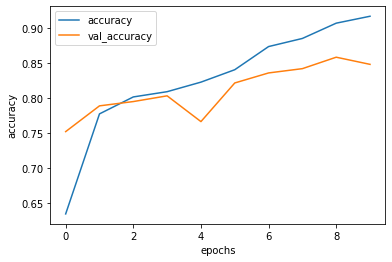

In [61]:
df = pd.DataFrame(history_base.history)
df.plot(y=['accuracy', 'val_accuracy'], xlabel='epochs', ylabel='accuracy')

In [65]:
#model_base.save('covidModel.h5')
model_base.save_weights('covidModel_weigths.h5')

In [63]:
x_tes, y_tes = preprocessig_data(X_test)

In [64]:
score = model_base.evaluate(x_tes, y_tes, verbose=1)
print(f'Test loss: {score[0]}\nTest Accuracy: {score[1]}')

16/16 [==============================] - 6s 374ms/step - loss: 0.3361 - accuracy: 0.8439
Test loss: 0.336134672164917
Test Accuracy: 0.8439425230026245


In [76]:
h = tf.keras.models.Sequential([
  
  Conv2D(30, kernel_size= (3,3), activation='relu', input_shape =(IMG_SIZE,IMG_SIZE,1)),
  MaxPooling2D(),
  Flatten(),
  Dense(200, activation='relu'),
  Dropout(0.2),
  Dense(3, activation= 'softmax')
])
h.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])


In [77]:
h.load_weights('covidModel_weigths.h5')

In [78]:
type(h)

keras.engine.sequential.Sequential

In [79]:
score = h.evaluate(x_tes, y_tes, verbose=1)
print(f'Test loss: {score[0]}\nTest Accuracy: {score[1]}')

16/16 [==============================] - 7s 421ms/step - loss: 0.3361 - accuracy: 0.8439
Test loss: 0.336134672164917
Test Accuracy: 0.8439425230026245


# Encontrar hiperparametros

## Decidimos variar el numero de filtros de la capa de convolucion, el numero de neuronas y la activacion de la capa oculta y el valor del dropout

In [15]:
def search_model(num_filters = 32, rnn = 256, dropout = 0.15, activacion_oculta = 'relu'):
    clf = Sequential()
    clf.add(Conv2D(num_filters, kernel_size= (3,3), activation='relu', input_shape =(IMG_SIZE,IMG_SIZE,1)))
    clf.add(MaxPooling2D())
    clf.add(Flatten())
    clf.add(Dense(rnn, activation=activacion_oculta))
    clf.add(Dropout(dropout))
    clf.add(Dense(3, activation= 'softmax'))

    clf.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    return clf
    

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=search_model, verbose=1, batch_size=40, validation_data= (x_va, y_va), epochs = 10, callbacks=[early])
    

In [16]:

param_grid = dict(
                  num_filters = [20, 30, 40],
                  rnn = [200, 250, 300],
                  dropout = [0.1,0.2,0.3],
                  activacion_oculta = ['relu','sigmoid']
                  )

grid = RandomizedSearchCV(modelCV, param_grid, verbose=1, cv = 3, n_iter=5, random_state=20)



In [17]:
grid_result = grid.fit(x_tr,y_tr)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/10
49/49 [==============================] - 86s 2s/step - loss: 6.5366 - accuracy: 0.6215 - val_loss: 0.5671 - val_accuracy: 0.7357
Epoch 2/10
49/49 [==============================] - 81s 2s/step - loss: 0.3798 - accuracy: 0.8508 - val_loss: 0.4179 - val_accuracy: 0.8361
Epoch 3/10
49/49 [==============================] - 84s 2s/step - loss: 0.2372 - accuracy: 0.9144 - val_loss: 0.3265 - val_accuracy: 0.8709
Epoch 4/10
49/49 [==============================] - 82s 2s/step - loss: 0.1405 - accuracy: 0.9564 - val_loss: 0.3027 - val_accuracy: 0.8811
Epoch 5/10
49/49 [==============================] - 76s 2s/step - loss: 0.0861 - accuracy: 0.9795 - val_loss: 0.3220 - val_accuracy: 0.8770
Epoch 6/10
49/49 [==============================] - 76s 2s/step - loss: 0.0601 - accuracy: 0.9872 - val_loss: 0.3113 - val_accuracy: 0.8852
Epoch 7/10
49/49 [==============================] - 76s 2s/step - loss: 0.0428 - accuracy: 0.9918 - 

In [18]:
best_model = grid.best_estimator_

In [22]:
best_model.model.save('best_model')

INFO:tensorflow:Assets written to: best_model\assets


In [66]:
best_model_hyperparam = best_model.model.get_config()
print(best_model_hyperparam)

{'name': 'sequential_15', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 244, 244, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_15_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': True, 'batch_input_shape': (None, 244, 244, 1), 'dtype': 'float32', 'filters': 30, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_15', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_l

Como se aprecia en la celda anterior para este caso los mejores hiperparametros encontrados fueron:
- num_filters = 30 
- rnn = 200 
- activacion = 'relu'
- dropout = 0,2

In [28]:
score_best_model = best_model.model.evaluate(x_tes, y_tes, verbose=1)
print(f'Test loss: {score_best_model[0]}\nTest Accuracy: {score_best_model[1]}')

16/16 [==============================] - 4s 235ms/step - loss: 0.2783 - accuracy: 0.9199
Test loss: 0.2783285677433014
Test Accuracy: 0.9199178814888


## Modelo sin convolución
Quitamos la capa de convolución y solo aplanamos los datos con Flatten

In [51]:
model_no_conv = tf.keras.models.Sequential([
  Flatten(input_shape =(IMG_SIZE,IMG_SIZE,1)),
  Dense(300, activation='relu'),
  Dropout(0.20),
  Dense(3, activation= 'softmax')
])

model_no_conv.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
history_no_conv = model_no_conv.fit(x_tr, y_tr, validation_data= (x_va, y_va), batch_size=40, epochs = 10, callbacks=[early])

Epoch 1/10
74/74 [==============================] - 9s 120ms/step - loss: 4.7063 - accuracy: 0.6256 - val_loss: 0.8431 - val_accuracy: 0.5389
Epoch 2/10
74/74 [==============================] - 8s 113ms/step - loss: 0.6679 - accuracy: 0.6858 - val_loss: 0.5678 - val_accuracy: 0.7357
Epoch 3/10
74/74 [==============================] - 9s 116ms/step - loss: 0.6073 - accuracy: 0.7190 - val_loss: 0.5392 - val_accuracy: 0.7582
Epoch 4/10
74/74 [==============================] - 9s 115ms/step - loss: 0.5987 - accuracy: 0.7179 - val_loss: 0.5358 - val_accuracy: 0.7377
Epoch 5/10
74/74 [==============================] - 9s 116ms/step - loss: 0.5765 - accuracy: 0.7231 - val_loss: 0.4883 - val_accuracy: 0.7930
Epoch 6/10
74/74 [==============================] - 9s 116ms/step - loss: 0.5718 - accuracy: 0.7183 - val_loss: 0.4733 - val_accuracy: 0.7643
Epoch 7/10
74/74 [==============================] - 9s 116ms/step - loss: 0.5667 - accuracy: 0.7268 - val_loss: 0.5085 - val_accuracy: 0.7705
Epoch 

In [57]:
score_model_noConv = model_no_conv.evaluate(x_tes, y_tes, verbose=1)
print(f'Test loss: {score_model_noConv[0]}\nTest Accuracy: {score_model_noConv[1]}')

16/16 [==============================] - 0s 17ms/step - loss: 0.5378 - accuracy: 0.7351
Test loss: 0.5378245115280151
Test Accuracy: 0.7351129651069641


In [58]:
model_no_conv.save('model_no_conv')

INFO:tensorflow:Assets written to: model_no_conv\assets


## Resultados de los modelos realizados

In [59]:
#modelo_base
y_pred_base = model_base.predict(x_tes)
y_pred_base = y_pred_base.argmax(axis=-1)

#modelo_best
y_pred_best = best_model.model.predict(x_tes)
y_pred_best = y_pred_best.argmax(axis=-1)

#modelo_no_conv
y_pred_noConv = model_no_conv.predict(x_tes)
y_pred_noConv = y_pred_noConv.argmax(axis=-1)


In [63]:

Y_test = y_tes.argmax(axis=-1)
print('Reporte para el modelo base construido'.center(60,'-'))
print(classification_report(Y_test, y_pred_base, target_names=['COVID', 'Normal', 'Viral_Pneumonia']))
print('Reporte para el modelo sin convolucion'.center(60,'-'))
print(classification_report(Y_test, y_pred_noConv, target_names=['COVID', 'Normal', 'Viral_Pneumonia']))
print('Reporte para el mejor modelo entonado'.center(60,'-'))
print(classification_report(Y_test, y_pred_best, target_names=['COVID', 'Normal', 'Viral_Pneumonia']))

-----------Reporte para el modelo base construido-----------
                 precision    recall  f1-score   support

          COVID       0.83      0.91      0.87       153
         Normal       0.93      0.77      0.84       154
Viral_Pneumonia       0.92      0.98      0.95       180

       accuracy                           0.89       487
      macro avg       0.89      0.89      0.89       487
   weighted avg       0.89      0.89      0.89       487

-----------Reporte para el modelo sin convolucion-----------
                 precision    recall  f1-score   support

          COVID       0.72      0.46      0.57       153
         Normal       0.61      0.84      0.71       154
Viral_Pneumonia       0.89      0.88      0.88       180

       accuracy                           0.74       487
      macro avg       0.74      0.73      0.72       487
   weighted avg       0.75      0.74      0.73       487

-----------Reporte para el mejor modelo entonado------------
             

## Realizar predicciones a una imagen en particular

In [26]:
model_load = load_model('covidModel.h5')

In [29]:
def prep_img(img_path):
    IMG_SIZE =244
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0

    img = np.array(img)

    img = img.reshape(-1,img.shape[0], img.shape[1], 1)
    return img



In [44]:
image_to_classify = prep_img('./COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-20.png')

In [41]:
order = ['COVID', 'NORMAL', 'Pneumonia Viral']

In [46]:
print(f'Clasification = {order[np.argmax(model_load.predict(image_to_classify))]}')

Clasification = COVID
